# LAB 4: Electrocardiograms and Neural Networks

In this lab, we will try to predict heart arrhythmia with LSTMs and 1-D CNNs.

We will use MIT-BIH Arrythmia dataset (https://www.physionet.org/content/mitdb/1.0.0/).
It consists of ECG recordings of several patients with sample rate 360 Hz. Experts annotated/classified specific points in the signals as normal, abnormal, or non beat.

**NOTE 1:** GPU is required for this lab.
You must change "Runtime type" to GPU from the "Runtime" tab ("Change Runtime type").

**NOTE 2:** If you face RAM/memory overflow issue in this lab, ensure that you train only one model in single COLAB session. Feel free to implement your own memory optimization tricks too.

In [2]:
# Import lib
import os
%pip install wfdb
import wfdb
import numpy as np
import pandas as pd
import urllib.request
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.signal
from pywt import wavedec, dwt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 KB 3.4 MB/s eta 0:00:00
  Attempting uninstall: SoundFile
    Found existing installation: soundfile 0.12.1
    Uninstalling soundfile-0.12.1:
      Successfully uninstalled soundfile-0.12.1


In [3]:
# Load database
urllib.request.urlretrieve('https://physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip', './mba_dataset.zip')
!unzip mba_dataset.zip -d mba_dataset
path_dataset='mba_dataset/mit-bih-arrhythmia-database-1.0.0/'

Archive:  mba_dataset.zip
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/100.atr  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/100.dat  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/100.hea  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/100.xws  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/101.atr  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/101.dat  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/101.hea  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/101.xws  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/102-0.atr  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/102.atr  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/102.dat  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/102.hea  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/102.xws  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/103.atr  
  infl

**Explore database**

We will primarily use \<patientID>.atr files (patientID is being 100, 101, etc.). There are 48 patients with a 30 minutes of recording for each.
For '100' patient, let us check what all annotations are present in his/her signal. Run the code below.

In [4]:
# We provide function for loading an ECG file
def load_ECG_file(path):
    '''
    Input: path for patient files (excluding extension)
    Output: ECG signal, symbols (labels), indices for such symbols
    '''
    record = wfdb.rdrecord(path)
    annotation = wfdb.rdann(path, 'atr')
    signal = record.p_signal[:,0]    # ECG signal
    symbol = annotation.symbol  # symbols, annotation
    index = annotation.sample  # annotation index, R
    return signal, symbol, index
signal, symbol, index = load_ECG_file(os.path.join(path_dataset, '100'))  # check for yourself "signal" is ~30 min duration
print(f'Length of signal: {len(signal)}')  # ECG signal length (in terms of samples and NOT seconds); think why this corresponds to ~30 minutes of signal
print(f'Annotation symbols: {symbol}')  # annotation symbols
print(f'Annotation indices: {index}')  # annotion indices of symbols for patient 


Length of signal: 650000
Annotation symbols: ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',

In [5]:
print(len(index))

2274


We can see a lot of 'N' symbols. It refers to "normal" heartbeat.
The list of abnormal symbols are provided below, which we will consider as "abnormal" beats in this lab.
Any other symbol encountered in the dataset refer to "non-beat" and you **must** skip them in data preparation.
For detailed explanation about symbols, refer to https://archive.physionet.org/physiobank/annotations.shtml

In [6]:
# list of symbols for abnormal beats
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

**TASK 1 Data visualization (10 points)**: Plot any random 10-second long portion of this ECG file (patient 100). Then plot any 1-second portion of this ECG file (patient 100) which has an abnormality approximately in the middle of the signal.

Populating the interactive namespace from numpy and matplotlib


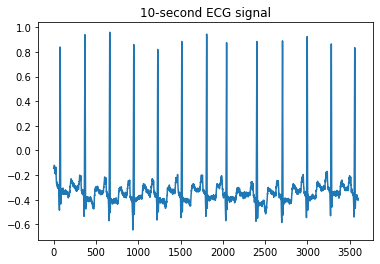

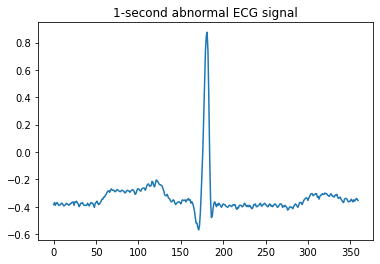

In [7]:
# Your code here
%pylab inline 
import matplotlib.pyplot as plt
## header
#header = wfdb.rdheader(os.path.join(path_dataset, '100'))
#display(header.__dict__)

##record, read all
#record = wfdb.rdrecord(os.path.join(path_dataset, '100'), sampfrom=0, sampto=3600)
#display(record.__dict__)
#wfdb.plot_wfdb(record=record, title='10-second ECG signal') 

plt.plot(signal[0:3600])
plt.title("10-second ECG signal")
plt.show()

#read atr
#annotation = wfdb.rdann(os.path.join(path_dataset, '100'), 'atr', sampfrom=100, sampto=3700)
#wfdb.plot_wfdb(annotation=annotation, time_units='seconds')

#for i in range(len(symbol)):
  #if symbol[i] is in abnormal:

#symbol,index(abnormal)
ind = list(np.isin(symbol,abnormal)).index(True)
start = index[ind]-180
end = index[ind]+180
#print(start,end)
plt.plot(signal[start:end])
plt.title("1-second abnormal ECG signal")
plt.show()


**TASK 2 Data preparation (10 points)**: Training data or test data is usually represented by a matrix $X \in \mathbb{R}^{N\times D}$. N represents the number of training points, and D represents the data dimension. We will consider one data point as +/- 2 seconds sequence of samples centered around a Q wave (annotation). Therefore, $D = 4f$ , where $f$ is the sample rate. Your goal is to construct such data matrix $X$. Your function should also output the corresponding label vector $y \in \mathbb{R}^{N\times 1}$. Labels should be 0 for Normal and 1 for abnormal. You should get close to a total of 100k data points.  

**Here are the instructions for setting labels:**

**If your 4-second data contains at least one abnormal annotation, you need to set the label to 1.**



**Note 1:** Don't forget to ingore the non-beat symbols.

**Note 2:** Labels in abnormal list should all be set with label 1.

**Note 3:** The patients in the training set should be different from the patients in the test set. Split the patients roughly 70:30, or you can simply use the patient IDs that have been split into train/test which is given below.

In [35]:
# Splitted ID
# training patient IDs
pts_train = ['100','101','102','103','104','105','106','107',
       '108','109','111','112','113','114','115','116',
       '117','118','119','121','122','123','124','200',
       '201','202','203','205','207','208','209','210']

# testing patient IDs
pts_test = ['212','213','214','215','217','219','220','221',
      '222','223','228','230','231','232','233','234']

In [37]:
# Your code here
def make_simple_dataset(dataset):
  #x = np.empty(shape=[0, 4*360])
  #label = np.empty(shape=[0])
  x = []
  label = []
  for i in dataset:
    #print(i)
    signal, symbol, index = load_ECG_file(os.path.join(path_dataset, i))
    index = index.tolist()
    remove = []
    # remove non-beat
    for j in range(len(symbol)):
      if symbol[j] not in abnormal and symbol[j] != 'N':
        remove.append(j)
    #print(remove)
    for r in sorted(remove, reverse=True):
      del symbol[r]
      del index[r]

    #print(len(index)==len(symbol))
    index = np.array(index)
    for ind in index:
      #print(ind)
      start = ind-720
      end = ind+720
      if start < 0 or end > len(signal):
        continue
      #tmp = np.array(signal[start:end])
      l = (index >= start)*(index<end)
      l = np.where(l)[0]
      ann = np.array(symbol)[l.astype(int)] 
      #print(ann) 
      if len(set(ann).intersection(set(abnormal))) > 0:
        #print(1)
        label.append(1)
      else:
        #print(0)
        label.append(0)
      tmp = signal[start:end]
      x.append(tmp)

  return np.array(x), np.array(label)

def make_dataset(pts_train,pts_test):
  '''
  Output: X_train, y_train, X_test y_test
  '''
  X_train,y_train = make_simple_dataset(pts_train)
  X_test,y_test= make_simple_dataset(pts_test)
  return X_train,y_train,X_test,y_test

X_train,y_train,X_test,y_test = make_dataset(pts_train,pts_test)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)


(70263, 1440) (70263,) (38954, 1440) (38954,)


**Task 3 Feature extraction (10 points)**: You will use Signal Processing lib [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html) to extract features for training and testing data matrices. We will do short-time Fourier transform to extract the spectrogram of ECG signal. 

**Note 1:** A common format of spectrogram is a graph with two geometric dimensions: one axis represents time, and the other axis represents frequency; a third dimension indicating the amplitude of a particular frequency at a particular time is represented by the intensity or color of each point in the image.

Examples of ECG spectrogram are shown below:

![ECG_spetrogram.jpg](https://d3i71xaburhd42.cloudfront.net/c86f76b6eeaa1ae92e5c96a68ca47d046fc01b2e/3-Figure2-1.png)

M. Salem, S. Taheri and J. Yuan, "ECG Arrhythmia Classification Using Transfer Learning from 2- Dimensional Deep CNN Features," 2018 IEEE Biomedical Circuits and Systems Conference (BioCAS), Cleveland, OH, USA, 2018, pp. 1-4, doi: 10.1109/BIOCAS.2018.8584808.


In [38]:
from scipy import signal
def extract_features(X):
  '''
  Input: X (N x D): Input data matrix
  Output: F (N x T x Feature)): Feature matrix
  '''
  fs = 360
  F = []
  for i in range(X.shape[0]):
    f, t, zxx = signal.stft(X[i], 360)
    F.append(zxx)

  return np.array(F)

X_train = extract_features(X_train)
X_test = extract_features(X_test)
print(X_train.shape, X_test.shape)

(70263, 129, 13) (38954, 129, 13)


**Task 4 Distribution and compensation for imbalance (10 points)**: Plot the distribution of percentage of oberservations with normal and abnormal labels in training set. Is the dataset balanced? If not, how could you deal with this imbalanced dataset during training?


To deal with this, I randomly shuffle class 1 (more samples) and extract the same amount of samples of class 0 to make it a balanced dataset.

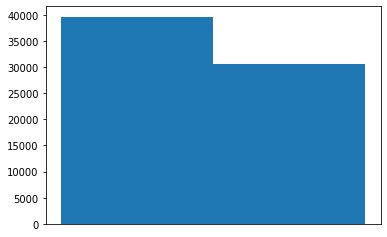

class 0: class 1 1.2942271272774766
there are  39637  class 0
there are  30626  class 1
30626 30626


In [39]:
# Your code here
#number = [sum(y_train[y_train==0]),sum(y_train[y_train==1])]
plt.hist(y_train,2)
plt.xticks([])
plt.show()

# Your solution if imbalanced
y_0 = np.where(y_train==0)[0]
y_1 = np.where(y_train==1)[0]
print("class 0: class 1",len(y_0)/len(y_1))
print("there are ", len(y_0)," class 0")
print("there are ", len(y_1)," class 1")
if len(y_0) > len(y_1):
  np.random.shuffle(y_0)
  y_0 = y_0[0:len(y_1)]
  y=np.append(y_0,y_1)
  print(len(y_0),len(y_1))
elif len(y_0) < len(y_1):
  np.random.shuffle(y_1)
  y_1 = y_1[0:len(y_0)]
  y=np.append(y_0,y_1)
  #print("more 1")
  print(len(y_0),len(y_1))
else:
  y=np.append(y_0,y_1)
  print(len(y_0),len(y_1))
#print(y)
#y_train = y_train[y]
#F_train = F_train[y]


In [40]:
y_train = y_train[y]
X_train = X_train[y]

**TASK 5 LSTM (25 points)**: Now, we are going to train a classifier to detect abnormal ECG cycles. We will train a simplified version of the LSTM-based network described in one of the [previously cited papers](https://www.sciencedirect.com/science/article/pii/S0010482518300738?casa_token=qrJ6hAf9tkYAAAAA:7uXqrKY5WqUM6Mjc_qg7wJ4R6QA02BGFXP0o_pOKN09yB8JIXb7067JZWY88rZc8M1G6gkkA). 

**Task 5.1:** Using Pytorch, create a single layer Bidirectional LSTM model. Followed by LSTM layer, you should have linear layer with sigmoid activation and a single output (we are predicting Normal/Abnormal).

**Task 5.2:** While creating your LSTM model, how could you validate your model in a real scientific experiment? (Describe and comment it in a text cell)

**Task 5.3:** Train and test your model, report your accuracy and F1-score on test set and train set. (You can find the definition and formula of accuracy, precision, recall-rate, and f1-score from this [link](https://towardsdatascience.com/the-f1-score-bec2bbc38aa6))

**Task 5.4:** What do you think is a way to increase the accuracy and F1-score? Try it and show if it is helpful.

**Note 1:** Print the loss function and accuracy while training to make sure your model works. 

**Note 2:** You need to add a flattening layer after LSTM layer (and before linear layer). 

**Note 3:** The output of LSTM in pytorch lib have a tuple outout, add the following GetLSTMOutput after your layer

In [13]:
import torch
import torch.nn as nn

In [14]:
# Layer after LSTM
class GetLSTMOutput(nn.Module):
    def forward(self, x):
        out,_ = x
        return out

In [41]:
# Adapt your input to tensor
F_train = torch.from_numpy(X_train).float()
F_test= torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

In [42]:
class Dataset_name():
  def __init__(self, signal, label):
    self.signal = signal
    self.label = label
  def __len__(self):
    return len(self.signal)

  def __getitem__(self, index):
    x = self.signal[index]
    y = self.label[index]
    return x, y

train_loader = torch.utils.data.DataLoader(Dataset_name(F_train,y_train), batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(Dataset_name(F_test,y_test), batch_size=32, shuffle=True)

In [50]:
# CODE HERE
# nn.Sequential()
class bidirectional_lstm(nn.Module):
  def __init__(self,):
    super(bidirectional_lstm,self).__init__()
    self.lstm = nn.LSTM(129, 6, 1, batch_first=True, bidirectional=True)
    self.flat = nn.Flatten()
    self.fc1 = nn.Linear(156,1)
    self.clf = nn.Sigmoid()

  def forward(self,x):
    output,_ = self.lstm(x)
    #print(output.shape)
    output = self.flat(output)
    #print(output.shape)
    output = self.fc1(output)
    #print(output.shape)
    output = self.clf(output)
    return output


**Task 5.2:** While creating your LSTM model, how could you validate your model in a real scientific experiment? (Describe and comment it in a text cell)

I will split the training data into train and validation set. With trying a bunch of hyperparameters (such as, hidden layer,num_layers) and test with validation set. Choose the hyperparameter have the highest accuracy for validation set. 

In [18]:
# 5.3 
def accuracy_f1_score(y_pred, y_true):
  tp = 0.001
  tn = 0.001
  fp = 0.001
  fn = 0.001
  total = len(y_pred)
  for i in range(total):
    if y_pred[i] == 0 and y_true[i] == 0:
      tn +=1
    elif y_pred[i] == 0 and y_true[i] == 1:
      fn +=1
    elif y_pred[i] == 1 and y_true[i] == 1:
      tp +=1
    elif y_pred[i] == 1 and y_true[i] == 0:
      fp +=1
  #print(tp,tn,fp,fn,total)
  accuracy = (tp+tn)/total
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f1 = 2*(precision*recall/(precision+recall))
  return round(accuracy,2),round(f1,2)


In [51]:
# Train model
criterion = nn.BCELoss()
model = bidirectional_lstm()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
#train_acc = []
#train_f1 = []
#test_acc = []
#test_f1 = []

for epoch in range(5):
  print("epoch", epoch)
  model.train()
  accuracy = 0
  f1_score = 0
  loss_item = 0
  for i, data in enumerate(train_loader, 0): # each time, load a batch of data from data loader
    # get the inputs; data is a list of [inputs, labels]
    #print(i)
    input, label = data
    optimizer.zero_grad()
    input = torch.permute(input, (0, 2, 1))
    output = model(input)
    loss = criterion(output,label.unsqueeze(1))
    loss_item += loss.item()
    loss.backward()
    output_label = output.detach().numpy() > 0.5
    acc,f1 = accuracy_f1_score(output_label, label)
    accuracy+=acc
    f1_score+=f1
    optimizer.step()
  
  print("train_accuracy: ", accuracy/(i+1))
  print("train_f1: ",f1_score/(i+1))
  print("train_loss: ",loss_item/(i+1) )
    

  model.eval()
  accuracy_t = 0
  f1_score_t = 0
  with torch.no_grad():
    for j, data in enumerate(test_loader, 0):
      input, label = data
      input = torch.permute(input, (0, 2, 1))
      output = model(input)
      output_label = output.detach().numpy() > 0.5
      acc,f1 = accuracy_f1_score(output_label, label)
      f1_score_t +=f1
      accuracy_t += acc
    
    print("test_accuracy: ",accuracy_t/(j+1))
    print("test_f1: ",f1_score_t/(j+1))


epoch 0
train_accuracy:  0.5815926892950375
train_f1:  0.6081462140992168
train_loss:  0.6859004751820477
test_accuracy:  0.5995155993431837
test_f1:  0.6993103448275845
epoch 1
train_accuracy:  0.5888720626631846
train_f1:  0.6478015665796346
train_loss:  0.6777279442035187
test_accuracy:  0.6002709359605902
test_f1:  0.693669950738915
epoch 2
train_accuracy:  0.5903080939947772
train_f1:  0.6481618798955611
train_loss:  0.6746305722169403
test_accuracy:  0.5990229885057455
test_f1:  0.6886863711001622
epoch 3
train_accuracy:  0.5960887728459524
train_f1:  0.6509608355091396
train_loss:  0.6728510400022601
test_accuracy:  0.6012315270935944
test_f1:  0.6943596059113282
epoch 4
train_accuracy:  0.6001723237597915
train_f1:  0.6502506527415147
train_loss:  0.6708628505079304
test_accuracy:  0.6017241379310333
test_f1:  0.6951642036124782


**5.4**: To increase f1 and accuracy, we can increase the epoch and increase learning rate a little bit

In [52]:
# Train model
criterion = nn.BCELoss()
model = bidirectional_lstm()
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)

for epoch in range(10):
  print("epoch", epoch)
  model.train()
  accuracy = 0
  f1_score = 0
  loss_item = 0
  for i, data in enumerate(train_loader, 0): # each time, load a batch of data from data loader
    # get the inputs; data is a list of [inputs, labels]
    #print(i)
    input, label = data
    input = torch.permute(input, (0, 2, 1))
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output,label.unsqueeze(1))
    loss_item += loss.item()
    loss.backward()
    output_label = output.detach().numpy() > 0.5
    acc,f1 = accuracy_f1_score(output_label, label)
    accuracy+=acc
    f1_score+=f1
    optimizer.step()
  
  print("train_accuracy: ", accuracy/(i+1))
  print("train_f1: ",f1_score/(i+1))
  print("train_loss: ",loss_item/(i+1) )
    

  model.eval()
  accuracy_t = 0
  f1_score_t = 0
  with torch.no_grad():
    for j, data in enumerate(test_loader, 0):
      input, label = data
      input = torch.permute(input, (0, 2, 1))
      output = model(input)
      output_label = output.detach().numpy() > 0.5
      acc,f1 = accuracy_f1_score(output_label, label)
      f1_score_t +=f1
      accuracy_t += acc
    
    print("test_accuracy: ",accuracy_t/(j+1))
    print("test_f1: ",f1_score_t/(j+1))


epoch 0
train_accuracy:  0.6302558746736323
train_f1:  0.6384177545691911
train_loss:  0.6411917458470745
test_accuracy:  0.6203940886699507
test_f1:  0.4934646962233175
epoch 1
train_accuracy:  0.7451488250652736
train_f1:  0.7276240208877264
train_loss:  0.5105274442515236
test_accuracy:  0.6875041050903116
test_f1:  0.6607307060755334
epoch 2
train_accuracy:  0.8073420365535223
train_f1:  0.7936449086161848
train_loss:  0.4107056903387797
test_accuracy:  0.7143924466338258
test_f1:  0.7010098522167495
epoch 3
train_accuracy:  0.8394516971279391
train_f1:  0.8298433420365505
train_loss:  0.357170971348765
test_accuracy:  0.7104926108374399
test_f1:  0.7014696223316911
epoch 4
train_accuracy:  0.853900783289823
train_f1:  0.8446997389033928
train_loss:  0.3283479574532795
test_accuracy:  0.692602627257801
test_f1:  0.6781609195402309
epoch 5
train_accuracy:  0.8672114882506641
train_f1:  0.8588877284595292
train_loss:  0.3081556430606867
test_accuracy:  0.6256157635467977
test_f1:  0.

**TASK 6 1-D CNNs (25 points)**: Different to LSTM model, we will have [1D CNN](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html) layer with ReLU activation. You need to add a flattening layer just after this (and before linear layer).

**Task 6.1:** Using Pytorch, create a deep CNN model (more than 1 layer). Followed by CNN layer, you should have one or several linear layers with different kinds of activation and number of final output units equals to 1.

**Task 6.2:** While creating your deep CNN model, how do you validate your model? (Describe and comment it in a text cell)

**Task 6.3:** Train and test your model, report your accuracy and F1-score on test set and train set.

**Task 6.4:** What do you think is a way to increase the accuracy and F1-score? Try it and show if it is helpful.

**Task 6.5:** Comment the difference between your CNN and LSTM models.

**Note 1:** Print the loss function and accuracy while training to make sure your model works. 

**Note 2:** You need to add a flattening layer after LSTM layer (and before linear layer). 

**Note 3:** Sigmoid is recommended as the activation of your last linear layer.

In [ ]:
#6.1 CODE HERE
# nn.Sequential()
class CNN(nn.Module):
  def __init__(self,):
    super(CNN,self).__init__()
    #difference between lstm, first convolutional layer
    self.conv1 = nn.Conv1d(129, 100, 3, stride=2)
    # relu activation function
    self.relu = nn.ReLU()
    # second convolutional layer
    self.conv2 = nn.Conv1d(100, 80, 3, stride=2)
    # flatten all the layers
    self.flat = nn.Flatten()
    # several linear layers
    self.fc1 = nn.Linear(160,100)
    self.fc2 = nn.Linear(100,30)
    self.fc3 = nn.Linear(30,1)
    self.clf = nn.Sigmoid()

  def forward(self,x):
    output = self.conv1(x)
    #print(output.shape)
    output = self.relu(output)
    #print(output.shape)
    output = self.conv2(output)
    #print(output.shape)
    output = self.flat (output)
    #print(output.shape)
    output = self.fc1(output)
    #print(output.shape)
    output = self.fc2(output)
    output = self.fc3(output)
    output = self.clf(output)


    return output

**6.2**: We can validate our data through accuracy, loss, specificity, sensitivity and f1 score. 

In [ ]:
#6.3 Train model
criterion = nn.BCELoss()
model = CNN()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(5):
  print("epoch", epoch)
  model.train()
  accuracy = 0
  f1_score = 0
  loss_item = 0
  for i, data in enumerate(train_loader, 0): # each time, load a batch of data from data loader
    # get the inputs; data is a list of [inputs, labels]
    #print(i)
    input, label = data
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output,label.unsqueeze(1))
    loss_item += loss.item()
    loss.backward()
    output_label = output.detach().numpy() > 0.5
    acc,f1 = accuracy_f1_score(output_label, label)
    accuracy+=acc
    f1_score+=f1
    optimizer.step()
  
  print("train_accuracy: ", accuracy/(i+1))
  print("train_f1: ",f1_score/(i+1))
  print("train_loss: ",loss_item/(i+1) )
    

  model.eval()
  accuracy_t = 0
  f1_score_t = 0
  with torch.no_grad():
    for j, data in enumerate(test_loader, 0):
      input, label = data
      output = model(input)
      output_label = output.detach().numpy() > 0.5
      acc,f1 = accuracy_f1_score(output_label, label)
      f1_score_t +=f1
      accuracy_t += acc
    
    print("test_accuracy: ",accuracy_t/(j+1))
    print("test_f1: ",f1_score_t/(j+1))



epoch 0
train_accuracy:  0.5238381201044378
train_f1:  0.3389869451697126
train_loss:  0.6928611640208072
test_accuracy:  0.47023809523809534
test_f1:  0.0003776683087027914
epoch 1
train_accuracy:  0.5596187989556126
train_f1:  0.4295300261096594
train_loss:  0.6909983050107333
test_accuracy:  0.5939737274220017
test_f1:  0.6607635467980286
epoch 2
train_accuracy:  0.597284595300262
train_f1:  0.645644908616188
train_loss:  0.682139296693528
test_accuracy:  0.600155993431855
test_f1:  0.6885467980295545
epoch 3
train_accuracy:  0.5995509138381204
train_f1:  0.6544804177545699
train_loss:  0.6697030037563713
test_accuracy:  0.6054022988505737
test_f1:  0.6967487684729052
epoch 4
train_accuracy:  0.6404177545691946
train_f1:  0.6656657963446481
train_loss:  0.639222785947217
test_accuracy:  0.6525041050903118
test_f1:  0.6265599343185551


**6.4**
to increase accuracy and f1 score, we can increase the epoches, and increase the learning rate

In [ ]:
#6.4 Train model
criterion = nn.BCELoss()
model = CNN()
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)

for epoch in range(20):
  print("epoch", epoch)
  model.train()
  accuracy = 0
  f1_score = 0
  loss_item = 0
  for i, data in enumerate(train_loader, 0): # each time, load a batch of data from data loader
    # get the inputs; data is a list of [inputs, labels]
    #print(i)
    input, label = data
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output,label.unsqueeze(1))
    loss_item += loss.item()
    loss.backward()
    output_label = output.detach().numpy() > 0.5
    acc,f1 = accuracy_f1_score(output_label, label)
    accuracy+=acc
    f1_score+=f1
    optimizer.step()
  
  print("train_accuracy: ", accuracy/(i+1))
  print("train_f1: ",f1_score/(i+1))
  print("train_loss: ",loss_item/(i+1) )
    

  model.eval()
  accuracy_t = 0
  f1_score_t = 0
  with torch.no_grad():
    for j, data in enumerate(test_loader, 0):
      input, label = data
      output = model(input)
      output_label = output.detach().numpy() > 0.5
      acc,f1 = accuracy_f1_score(output_label, label)
      f1_score_t +=f1
      accuracy_t += acc
    
    print("test_accuracy: ",accuracy_t/(j+1))
    print("test_f1: ",f1_score_t/(j+1))


epoch 0
train_accuracy:  0.7342297650130581
train_f1:  0.7087101827676222
train_loss:  0.5102115111430382
test_accuracy:  0.6730049261083747
test_f1:  0.623891625615763
epoch 1
train_accuracy:  0.8706109660574521
train_f1:  0.861248041775458
train_loss:  0.361274029199744
test_accuracy:  0.6922988505747143
test_f1:  0.6322824302134641
epoch 2
train_accuracy:  0.8913629242819993
train_f1:  0.8823080939947828
train_loss:  0.32118571882401215
test_accuracy:  0.7184646962233188
test_f1:  0.720919540229885
epoch 3
train_accuracy:  0.8992532637075896
train_f1:  0.8903550913838204
train_loss:  0.3023529692920163
test_accuracy:  0.6961986863711012
test_f1:  0.645451559934318
epoch 4
train_accuracy:  0.9041984334203852
train_f1:  0.8963603133159357
train_loss:  0.28288766285380246
test_accuracy:  0.6831198686371106
test_f1:  0.6926354679802963
epoch 5
train_accuracy:  0.9111279373368378
train_f1:  0.9027832898172423
train_loss:  0.26920111074109926
test_accuracy:  0.6939244663382607
test_f1:  0

**Task 7 Alexnet (10 points):** AlexNet is a deep convolutional neural network (CNN) designed by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton, which achieved a significant breakthrough in the field of computer vision by winning the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2012. It was one of the first deep neural networks to use multiple layers and dropout regularization to prevent overfitting. You can find the introduction of Alexnet in this paper ["ImageNet Classification with Deep Convolutional
Neural Networks"](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

**Task 7.1**: Establish and train a AlexNet which is similiar to the AlexNet of the paper: ["Classification of ECG signal using FFT based improved Alexnet classifier"](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9514660/) The structure of Alex Net is shown below.

**Task 7.2**: Train and test AlexNet, report accuracy and F1-score on test set and train set.

**Note 1**: If you think the features are too less for so many layers, you can use one conv layer to replace conv 3 - conv 5 and one linear layer to replace FC 6 - FC 8.

**Note 2**: You can add dropout layer if needed. 

**Note 3**: You can set hyperparameters yourself.

![AlexNet](https://www.ncbi.nlm.nih.gov/corecgi/tileshop/tileshop.fcgi?p=PMC3&id=166618&s=150&r=1&c=1)

Kumar M A, Chakrapani A. Classification of ECG signal using FFT based improved Alexnet classifier. PLoS One. 2022;17(9):e0274225. Published 2022 Sep 27. doi:10.1371/journal.pone.0274225

In [ ]:
# 7.1 CODE HERE
# nn.Sequential()
class alexnet(nn.Module):
  def __init__(self,):
    super(alexnet,self).__init__()
    #conv 1
    self.conv1 = nn.Conv1d(129, 129, 10, stride=1,padding =1)
    #max
    self.max = nn.MaxPool2d(2,2)
    # conv2
    self.conv2 = nn.Conv1d(64, 64, 3, stride=1,padding =1)
    # conv3 - conv5
    self.conv3 = nn.Conv1d(32, 32, 1, stride=1,padding =1)
    self.flat = nn.Flatten()
    # fc6-8
    self.fc = nn.Linear(16,1)
    self.clf = nn.Sigmoid()

  def forward(self,x):
    output = self.conv1(x)
    output = self.max(output)
    output = self.conv2(output)
    output = self.max(output)
    output = self.conv3(output)
    output = self.max(output)
    output = self.flat (output)
    #print(output.shape)
    output = self.fc(output)
    output = self.clf(output)


    return output

In [ ]:
# 7.2 Train model
criterion = nn.BCELoss()
model = alexnet()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in range(15):
  print("epoch", epoch)
  model.train()
  accuracy = 0
  f1_score = 0
  loss_item = 0
  for i, data in enumerate(train_loader, 0): # each time, load a batch of data from data loader
    # get the inputs; data is a list of [inputs, labels]
    #print(i)
    input, label = data
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output,label.unsqueeze(1))
    loss_item += loss.item()
    loss.backward()
    output_label = output.detach().numpy() > 0.5
    acc,f1 = accuracy_f1_score(output_label, label)
    accuracy+=acc
    f1_score+=f1
    optimizer.step()
  
  print("train_accuracy: ", accuracy/(i+1))
  print("train_f1: ",f1_score/(i+1))
  print("train_loss: ",loss_item/(i+1) )
    

  model.eval()
  accuracy_t = 0
  f1_score_t = 0
  with torch.no_grad():
    for j, data in enumerate(test_loader, 0):
      input, label = data
      output = model(input)
      output_label = output.detach().numpy() > 0.5
      acc,f1 = accuracy_f1_score(output_label, label)
      f1_score_t +=f1
      accuracy_t += acc
    
    print("test_accuracy: ",accuracy_t/(j+1))
    print("test_f1: ",f1_score_t/(j+1))


epoch 0
train_accuracy:  0.7196449086161908
train_f1:  0.7067467362924279
train_loss:  0.5260487429505851
test_accuracy:  0.6964203612479481
test_f1:  0.7342857142857121
epoch 1
train_accuracy:  0.8827154046997536
train_f1:  0.8742454308094033
train_loss:  0.28080272260109845
test_accuracy:  0.693842364532022
test_f1:  0.6653612479474558
epoch 2
train_accuracy:  0.9085587467363122
train_f1:  0.9011540469973967
train_loss:  0.22503991494485354
test_accuracy:  0.6909277504105105
test_f1:  0.7005254515599357
epoch 3
train_accuracy:  0.9208772845953237
train_f1:  0.9138224543081055
train_loss:  0.19709135531095237
test_accuracy:  0.6865024630541876
test_f1:  0.7093513957307074
epoch 4
train_accuracy:  0.9276449086162128
train_f1:  0.921488250652756
train_loss:  0.17992703326668968
test_accuracy:  0.6730213464696234
test_f1:  0.7449261083743837
epoch 5
train_accuracy:  0.9338485639686929
train_f1:  0.9281409921671181
train_loss:  0.16709689709939082
test_accuracy:  0.6724384236453207
test_f

**Task 8 Bonus (20 points)**: You can choose between task 8.1 and task 8.2 to get all bonus credits.

**Task 8.1**: In this task, you need to reconstruct the matrix for training and test data. As described before, each R wave in the database is annotated with normal or abnormal label. We will consider as an observation a time period with totally five Q waves centered around a Q wave with a annotation (normal/abnormal).Your goal is to construct such data matrix $X$. Your function should also output the corresponding label vector $y \in \mathbb{R}^{N\times 1}$. Labels should be 0 for Normal and 1 for abnormal. After data preparation, You need to repeat task 3, task 4, task 5 and task 6 with your new data.

**Note 1**: Each of your observation may have different length of data, you need to padding them while training CNN model in task6.

**Task 8.2**: Gated recurrent units (GRUs) are a gating mechanism in recurrent neural networks, [introduced in 2014 by Kyunghyun Cho et al](https://arxiv.org/abs/1409.1259). You need to create your own GRUs, train and test the model, and report accuracy and F1-score on train set and test set. Compare the results of GRUs with results of LSTM and CNN, what do you observe?

In [53]:
# Task 8.1
# Your code here
def make_simple_dataset2(dataset):
  #x = np.empty(shape=[0, 4*360])
  #label = np.empty(shape=[0])
  x = []
  label = []
  #max = []
  for i in dataset:
    #print(i)
    signal, symbol, index = load_ECG_file(os.path.join(path_dataset, i))

    for indice in range(2,(len(index)-2)):
      s = indice-2
      e = indice +2
      start = index[s]
      end = index[e]

      length = end-start+1

      start -= int((3781 - length)/2)
      end += (3781 - length)-int((3781 - length)/2)

      if start < 0 or end > len(signal):
        continue
      
      ann = symbol[indice]
      #print(ann)
      if ann not in abnormal and ann != 'N':
        continue
      elif ann in abnormal:
            #print(1)
        label.append(1)
      else:            
        label.append(0)

      tmp = signal[start:end]
      #max.append(len(tmp))
      #print(len(tmp))
      x.append(tmp)
#
  return np.array(x), np.array(label)

def make_dataset2(pts_train,pts_test):
  '''
  Output: X_train, y_train, X_test y_test
  '''
  X_train,y_train = make_simple_dataset2(pts_train)
  X_test,y_test= make_simple_dataset2(pts_test)
  return X_train,y_train,X_test,y_test


X_train,y_train,X_test,y_test = make_dataset2(pts_train,pts_test)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)


(70008, 3780) (70008,) (38810, 3780) (38810,)


In [54]:
X_train = extract_features(X_train)
X_test = extract_features(X_test)
print(X_train.shape, X_test.shape)

(70008, 129, 31) (38810, 129, 31)


In [55]:
# Your solution if imbalanced
y_0 = np.where(y_train==0)[0]
y_1 = np.where(y_train==1)[0]
print("class 0: class 1",len(y_0)/len(y_1))
print("there are ", len(y_0)," class 0")
print("there are ", len(y_1)," class 1")
if len(y_0) > len(y_1):
  np.random.shuffle(y_0)
  y_0 = y_0[0:len(y_1)]
  y=np.append(y_0,y_1)
  print(len(y_0),len(y_1))
elif len(y_0) < len(y_1):
  np.random.shuffle(y_1)
  y_1 = y_1[0:len(y_0)]
  y=np.append(y_0,y_1)
  #print("more 1")
  print(len(y_0),len(y_1))
else:
  y=np.append(y_0,y_1)
  print(len(y_0),len(y_1))
#print(y)
y_train = y_train[y]
X_train = X_train[y]

class 0: class 1 2.2421618116982356
there are  48415  class 0
there are  21593  class 1
21593 21593


In [56]:
# Adapt your input to tensor
F_train = torch.from_numpy(X_train).float()
F_test= torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()


In [57]:
train_loader = torch.utils.data.DataLoader(Dataset_name(F_train,y_train), batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(Dataset_name(F_test,y_test), batch_size=32, shuffle=True)

**task 5**

In [62]:
# CODE HERE
# nn.Sequential()
class bidirectional_lstm(nn.Module):
  def __init__(self,):
    super(bidirectional_lstm,self).__init__()
    self.lstm = nn.LSTM(129, 2, 1, batch_first=True, bidirectional=True)
    self.flat = nn.Flatten()
    self.fc1 = nn.Linear(124,80)
    self.fc2 = nn.Linear(80,1)
    self.clf = nn.Sigmoid()

  def forward(self,x):
    #print(x.shape)
    output,_ = self.lstm(x)
    #print(output.shape)
    output = self.flat(output)
    #print(output.shape)
    output = self.fc1(output)
    output = self.fc2(output)
    #print(output.shape)
    output = self.clf(output)
    return output


In [63]:
# Train model
criterion = nn.BCELoss()
model = bidirectional_lstm()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(5):
  print("epoch", epoch)
  model.train()
  accuracy = 0
  f1_score = 0
  loss_item = 0
  for i, data in enumerate(train_loader, 0): # each time, load a batch of data from data loader
    # get the inputs; data is a list of [inputs, labels]
    #print(i)
    input, label = data
    input = torch.permute(input, (0, 2, 1))
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output,label.unsqueeze(1))
    loss_item += loss.item()
    loss.backward()
    output_label = output.detach().numpy() > 0.5
    acc,f1 = accuracy_f1_score(output_label, label)
    accuracy+=acc
    f1_score+=f1
    optimizer.step()
  
  print("train_accuracy: ", accuracy/(i+1))
  print("train_f1: ",f1_score/(i+1))
  print("train_loss: ",loss_item/(i+1) )
    

  model.eval()
  accuracy_t = 0
  f1_score_t = 0
  with torch.no_grad():
    for j, data in enumerate(test_loader, 0):
      input, label = data
      input = torch.permute(input, (0, 2, 1))
      output = model(input)
      output_label = output.detach().numpy() > 0.5
      acc,f1 = accuracy_f1_score(output_label, label)
      f1_score_t +=f1
      accuracy_t += acc
    
    print("test_accuracy: ",accuracy_t/(j+1))
    print("test_f1: ",f1_score_t/(j+1))


epoch 0
train_accuracy:  0.5120962962962948
train_f1:  0.33444444444444427
train_loss:  0.6926519824398889
test_accuracy:  0.5321434460016476
test_f1:  0.484097279472382
epoch 1
train_accuracy:  0.5519999999999986
train_f1:  0.5479629629629628
train_loss:  0.6899116796034354
test_accuracy:  0.5205358615004118
test_f1:  0.4936108821104697
epoch 2
train_accuracy:  0.5704074074074057
train_f1:  0.6190444444444451
train_loss:  0.6866527974605561
test_accuracy:  0.48333882934872263
test_f1:  0.5244517724649622
epoch 3
train_accuracy:  0.576044444444443
train_f1:  0.6321777777777781
train_loss:  0.685469291166023
test_accuracy:  0.4749711459192094
test_f1:  0.5257543281121184
epoch 4
train_accuracy:  0.5775851851851838
train_f1:  0.6317259259259248
train_loss:  0.6849148026219121
test_accuracy:  0.47820280296784773
test_f1:  0.5251195383347066


In [65]:
#5 improve model 
# Train model
criterion = nn.BCELoss()
model = bidirectional_lstm()
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)

for epoch in range(15):
  print("epoch", epoch)
  model.train()
  accuracy = 0
  f1_score = 0
  loss_item = 0
  for i, data in enumerate(train_loader, 0): # each time, load a batch of data from data loader
    # get the inputs; data is a list of [inputs, labels]
    #print(i)
    input, label = data
    input = torch.permute(input, (0, 2, 1))
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output,label.unsqueeze(1))
    loss_item += loss.item()
    loss.backward()
    output_label = output.detach().numpy() > 0.5
    acc,f1 = accuracy_f1_score(output_label, label)
    accuracy+=acc
    f1_score+=f1
    optimizer.step()
  
  print("train_accuracy: ", accuracy/(i+1))
  print("train_f1: ",f1_score/(i+1))
  print("train_loss: ",loss_item/(i+1) )
    

  model.eval()
  accuracy_t = 0
  f1_score_t = 0
  with torch.no_grad():
    for j, data in enumerate(test_loader, 0):
      input, label = data
      input = torch.permute(input, (0, 2, 1))
      output = model(input)
      output_label = output.detach().numpy() > 0.5
      acc,f1 = accuracy_f1_score(output_label, label)
      f1_score_t +=f1
      accuracy_t += acc
    
    print("test_accuracy: ",accuracy_t/(j+1))
    print("test_f1: ",f1_score_t/(j+1))

epoch 0
train_accuracy:  0.6111629629629627
train_f1:  0.5659851851851846
train_loss:  0.6452895057201385
test_accuracy:  0.6018301731244848
test_f1:  0.4213602638087393
epoch 1
train_accuracy:  0.7723407407407376
train_f1:  0.7627259259259253
train_loss:  0.5062268822502207
test_accuracy:  0.505721352019785
test_f1:  0.45834295136026365
epoch 2
train_accuracy:  0.808244444444441
train_f1:  0.7980148148148131
train_loss:  0.4506008709801568
test_accuracy:  0.5674855729596026
test_f1:  0.4526215993404784
epoch 3
train_accuracy:  0.8295111111111086
train_f1:  0.8198888888888868
train_loss:  0.40398350774138064
test_accuracy:  0.6122835943940629
test_f1:  0.4556306677658705
epoch 4
train_accuracy:  0.8394814814814809
train_f1:  0.8295407407407395
train_loss:  0.3813990938773862
test_accuracy:  0.6379307502061003
test_f1:  0.4431327287716406
epoch 5
train_accuracy:  0.8461703703703694
train_f1:  0.8371629629629617
train_loss:  0.36730498404414563
test_accuracy:  0.6285408079142614
test_f1:

**task 6**

In [68]:
#6.1 CODE HERE
# nn.Sequential()
class CNN(nn.Module):
  def __init__(self,):
    super(CNN,self).__init__()
    #difference between lstm, first convolutional layer
    self.conv1 = nn.Conv1d(129, 100, 3, stride=2)
    # relu activation function
    self.relu = nn.ReLU()
    # second convolutional layer
    self.conv2 = nn.Conv1d(100, 80, 3, stride=2)
    # flatten all the layers
    self.flat = nn.Flatten()
    # several linear layers
    self.fc1 = nn.Linear(560,200)
    self.fc2 = nn.Linear(200,30)
    self.fc3 = nn.Linear(30,1)
    self.clf = nn.Sigmoid()

  def forward(self,x):
    #print(x.shape)
    output = self.conv1(x)
    #print(output.shape)
    output = self.relu(output)
    #print(output.shape)
    output = self.conv2(output)
    #print(output.shape)
    output = self.flat (output)
    #print(output.shape)
    output = self.fc1(output)
    #print(output.shape)
    output = self.fc2(output)
    output = self.fc3(output)
    output = self.clf(output)


    return output

In [69]:
#6.4 Train model
criterion = nn.BCELoss()
model = CNN()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(5):
  print("epoch", epoch)
  model.train()
  accuracy = 0
  f1_score = 0
  loss_item = 0
  for i, data in enumerate(train_loader, 0): # each time, load a batch of data from data loader
    # get the inputs; data is a list of [inputs, labels]
    #print(i)
    input, label = data
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output,label.unsqueeze(1))
    loss_item += loss.item()
    loss.backward()
    output_label = output.detach().numpy() > 0.5
    acc,f1 = accuracy_f1_score(output_label, label)
    accuracy+=acc
    f1_score+=f1
    optimizer.step()
  
  print("train_accuracy: ", accuracy/(i+1))
  print("train_f1: ",f1_score/(i+1))
  print("train_loss: ",loss_item/(i+1) )
    

  model.eval()
  accuracy_t = 0
  f1_score_t = 0
  with torch.no_grad():
    for j, data in enumerate(test_loader, 0):
      input, label = data
      output = model(input)
      output_label = output.detach().numpy() > 0.5
      acc,f1 = accuracy_f1_score(output_label, label)
      f1_score_t +=f1
      accuracy_t += acc
    
    print("test_accuracy: ",accuracy_t/(j+1))
    print("test_f1: ",f1_score_t/(j+1))

epoch 0
train_accuracy:  0.5110888888888879
train_f1:  0.24388148148148145
train_loss:  0.6930575958887736
test_accuracy:  0.3266281945589437
test_f1:  0.48694971145919264
epoch 1
train_accuracy:  0.5419481481481472
train_f1:  0.49922962962963024
train_loss:  0.6925011935057463
test_accuracy:  0.5636191261335504
test_f1:  0.45926628194558955
epoch 2
train_accuracy:  0.5617925925925915
train_f1:  0.5415703703703694
train_loss:  0.6915890525446998
test_accuracy:  0.4952267106347898
test_f1:  0.5173536685902707
epoch 3
train_accuracy:  0.5636222222222199
train_f1:  0.5727111111111103
train_loss:  0.6893740902565144
test_accuracy:  0.4640560593569665
test_f1:  0.5249464138499575
epoch 4
train_accuracy:  0.5708222222222215
train_f1:  0.6375481481481473
train_loss:  0.6856268648306528
test_accuracy:  0.4678730420445175
test_f1:  0.5255234954657858


In [ ]:
#6 improve model
criterion = nn.BCELoss()
model = CNN()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in range(15):
  print("epoch", epoch)
  model.train()
  accuracy = 0
  f1_score = 0
  loss_item = 0
  for i, data in enumerate(train_loader, 0): # each time, load a batch of data from data loader
    # get the inputs; data is a list of [inputs, labels]
    #print(i)
    input, label = data
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output,label.unsqueeze(1))
    loss_item += loss.item()
    loss.backward()
    output_label = output.detach().numpy() > 0.5
    acc,f1 = accuracy_f1_score(output_label, label)
    accuracy+=acc
    f1_score+=f1
    optimizer.step()
  
  print("train_accuracy: ", accuracy/(i+1))
  print("train_f1: ",f1_score/(i+1))
  print("train_loss: ",loss_item/(i+1) )
    

  model.eval()
  accuracy_t = 0
  f1_score_t = 0
  with torch.no_grad():
    for j, data in enumerate(test_loader, 0):
      input, label = data
      output = model(input)
      output_label = output.detach().numpy() > 0.5
      acc,f1 = accuracy_f1_score(output_label, label)
      f1_score_t +=f1
      accuracy_t += acc
    
    print("test_accuracy: ",accuracy_t/(j+1))
    print("test_f1: ",f1_score_t/(j+1))

epoch 0
train_accuracy:  0.5544296296296285
train_f1:  0.5272296296296295
train_loss:  0.6801104338963827
test_accuracy:  0.33460016488046146
test_f1:  0.48115416323165666
epoch 1
train_accuracy:  0.7984740740740722
train_f1:  0.7805111111111092
train_loss:  0.47283829002468675
test_accuracy:  0.6298763396537504
test_f1:  0.490362737015663
epoch 2
train_accuracy:  0.8596740740740746
train_f1:  0.8500962962962969
train_loss:  0.3960601254856145
test_accuracy:  0.6554080791426214
test_f1:  0.4629760923330586
epoch 3
train_accuracy:  0.8782518518518565
train_f1:  0.869903703703703
train_loss:  0.3691895658053734
test_accuracy:  0.6677576257213521
test_f1:  0.4488788128606762
epoch 4
train_accuracy:  0.888962962962971
train_f1:  0.8802370370370387
train_loss:  0.34725850395030444
test_accuracy:  0.6288458367683427
test_f1:  0.4941962077493817
epoch 5
train_accuracy:  0.8955629629629713
train_f1:  0.8882148148148165
train_loss:  0.32939781107836297
test_accuracy:  0.6332234130255554
test_f1

**You are ready to submit in Blackboard!**

Please suffix your colab file with _<jhID> 
o	eg: Lab4_ECG_LSTM_CNN_myjhID12

